<a href="https://colab.research.google.com/github/Svetorus/Computer_vision/blob/master/DP_HW_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка видео
Классификация действий по видео


## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tqdm.notebook import tqdm

In [3]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

     |████████████████████████████████| 2.3MB 2.8MB/s 


## Загрузка и распаковка датасета KTH

In [4]:
if 1:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

--2020-06-11 15:57:52--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2020-06-11 15:57:53--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.227.116
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.227.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘walking.zip’

walking.zip             [             <=>    ] 231.21M  3.43MB/s    in 71s     

2020-06-11 15:59:07 (3.25 MB/s) - ‘walking.zip’ saved [242442411]

--2020-06-11 15:59:08--  http://www.nada.kth.se/cvap/actions/jogging.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::

In [0]:
!rm *.zip

## Подготовка датасета для классификации

In [6]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [7]:
SUBSET_LEN = 200
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 200


посмотрим на размеры наших видеофайлов

In [8]:
%%time
shapes = []
for i in range(len(dataset)):
    videodata = skvideo.io.vread(dataset[i][0])
    shapes.append(videodata.shape)

CPU times: user 3.14 s, sys: 4.31 s, total: 7.45 s
Wall time: 36 s


In [9]:
print('Всего файлов {}\nМинимальное количество кадров {}\nМаксимальное количетво кадров {}'.format(len(shapes),sorted(shapes)[0][0], sorted(shapes)[-1][0]))

Всего файлов 200
Минимальное количество кадров 265
Максимальное количетво кадров 1120


как мы видим - у нас разное количество кадров в роликах, есть совсем маленькие, есть совсем большие

итак, что мы сделаем: мы возьмем ролики и повторим каждый из них до максимального количества кадров

In [0]:
# MAX_FRAMES = sorted(shapes)[-1][0]
MAX_FRAMES = 600

Напишем функцию, которая будет повторять ролик сам в себя до необходимого нам количества раз

In [0]:
def reshape_(np_video):
  tmp = np_video.copy()
  # если количество кадров в видео меньше максимального
  if np_video.shape[0] < MAX_FRAMES:
    # то определяем сколко раз надо повторить операцию vstack
    num_iter = round(MAX_FRAMES / np_video.shape[0]) + 1
    # создаем временный файл, в котором будем хранить повторы
    tmp = np_video.copy()
    # стакаем необходимое количество раз
    for iterations in range(num_iter):
      tmp = np.vstack((tmp, np_video))
      if tmp.shape[0] > MAX_FRAMES:
        break
    # так как мы повторяли ролик сам в себя несколько раз, то его длина может быть больше чем необходимая
    # поэтому возьмем только необходимое нам количество кадров
    tmp = tmp[:MAX_FRAMES, ...]
  return tmp

Теперь преобразуем каждый ролик до нужного нам размера и запишем его

In [12]:
if 1:
  for data in tqdm(dataset):
    path = data[0][:-3]
    np_video = skvideo.io.vread(data[0])
    new_video = reshape_(np_video)
    skvideo.io.vwrite(path + "mp4", new_video)

Теперь сделаем новый датасет

In [13]:
dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.mp4')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [14]:
%%time
shapes = []
for i in range(len(dataset)):
    videodata = skvideo.io.vread(dataset[i][0])
    shapes.append(videodata.shape)

CPU times: user 4.4 s, sys: 6.63 s, total: 11 s
Wall time: 52 s


In [15]:
print('Всего файлов {}\nМинимальное количество кадров {}\nМаксимальное количетво кадров {}'.format(len(shapes),sorted(shapes)[0][0], sorted(shapes)[-1][0]))

Всего файлов 200
Минимальное количество кадров 600
Максимальное количетво кадров 1120


Ну вот, чего мы собственно и добивались

## Визуализация кадра из видео

videodata shape: (725, 120, 160, 3)


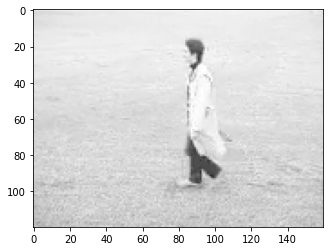

In [16]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...]);

## Визуализация "движения"

motion shape: (724, 120, 160, 1)


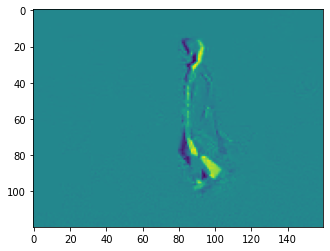

In [17]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

# Создание датасета

In [18]:
paths_ = []
labels_ = []

data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.mp4')):
        cls_idx = classes.index(cls)
        paths_.append(fpath)
        labels_.append(cls_idx)

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


Создадим функцию, которая бует считывать в датасет видеофайлы

In [0]:
def read_(fpath):
  video_to_np = skvideo.io.vread(fpath.numpy().decode())
  video_to_np = tf.cast(video_to_np, tf.float32) / 255
  return video_to_np

In [0]:
def tf_item_to_data(path, label):
    videodata = tf.py_function(read_, [path], [tf.float32])
    return videodata, label

In [0]:
import random

tmp_list = list(zip(paths_, labels_))
random.shuffle(tmp_list)

paths_, labels_ = zip(*tmp_list)

train_len = int(len(paths_) * 0.9)

paths_train = list(paths_[:train_len])
labels_train = list(labels_[:train_len])

paths_test = list(paths_[train_len:])
labels_test = list(labels_[train_len:])

In [0]:
BATCH_SIZE = 1
NUM_EPOCHS = 10

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((paths_train, labels_train))

In [0]:
test_ds = tf.data.Dataset.from_tensor_slices((paths_test, labels_test))

In [25]:
%%time
train_ds = train_ds.map(tf_item_to_data)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
# train_ds = train_ds.batch(BATCH_SIZE)

CPU times: user 57.5 ms, sys: 6.57 ms, total: 64.1 ms
Wall time: 85 ms


In [26]:
%%time
test_ds = test_ds.map(tf_item_to_data)
test_ds = test_ds.shuffle(buffer_size=1000)
# test_ds = test_ds.batch(BATCH_SIZE)

CPU times: user 7.82 ms, sys: 94 µs, total: 7.91 ms
Wall time: 7.21 ms


# Создание модели

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [28]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 724, 120, 160, 1)
Output shape: (1, 6)


In [0]:
LEARNING_RATE = 0.001

In [0]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

In [31]:
%%time
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/10][0/200] Loss = 1.7937273979187012
[0/10][10/200] Loss = 0.0
[0/10][20/200] Loss = 0.0
[0/10][30/200] Loss = 0.0
[0/10][40/200] Loss = 115.32601928710938
[0/10][50/200] Loss = 1.5939301252365112
[0/10][60/200] Loss = 1.639963150024414
[0/10][70/200] Loss = 0.3187417685985565
[0/10][80/200] Loss = 3.5483760833740234
[0/10][90/200] Loss = 1.6785457134246826
[0/10][100/200] Loss = 1.5236259698867798
[0/10][110/200] Loss = 2.198408365249634
[0/10][120/200] Loss = 1.7543575763702393
[0/10][130/200] Loss = 1.0106476545333862
[0/10][140/200] Loss = 3.688727617263794
[0/10][150/200] Loss = 1.7005360126495361
[0/10][160/200] Loss = 1.30031156539917
[0/10][170/200] Loss = 2.660595417022705
[0/10][180/200] Loss = 2.1174545288085938
[0/10][190/200] Loss = 1.8104984760284424
[1/10][0/200] Loss = 2.2382936477661133
[1/10][10/200] Loss = 2.0264346599578857
[1/10][20/200] Loss = 1.789476752281189
[1/10][30/200] Loss = 1.6492919921875
[1/10][40/200] Loss = 1.7845828533172607
[1/10][50/200] Loss = 

True class: jogging
Predicted class: jogging


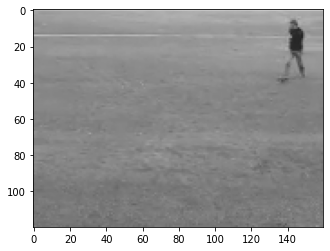

In [41]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])